# Qiskit Tutorial Part 3: Quantum Information

*This is part of the Qiskit Tutorial series by Yen Lee Loh.  Edited 2023-6-4.*

## 1. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import qute


$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$
$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$


## 2. Simulating Stern-Gerlach apparatuses using Qiskit

In a Stern-Gerlach apparatus, a beam of silver atoms passes through an inhomogeneous magnetic field. Each atom is deflected by a distance proportional to the $z$ component of its spin. Classically, we expect that $S_z$ has a continuous distribution.  However, in quantum mechanics, spin is quantized.  Each silver atom behaves like a spin-half particle whose magnetic spin quantum number can take only two values, $m=\pm\half$.  These states correspond to up-spin and down-spin states, which are equivalent to qubit states as follows:

$\beq
\ket{\uparrow} &= \ket{0} \\
\ket{\downarrow} &= \ket{1}.
\eeq$

If we use a beam stop to block all the spin-down atoms, the remaining beam contains only spin-up atoms: it is 100% spin-polarized.  This is equivalent to the following circuit, where a single qubit is initialized in $\ket{0}$:

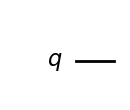

In [2]:
cir = qiskit.QuantumCircuit(1); cir.draw('mpl')    # circuit with 1 qubit and no gates

Now suppose the Stern-Gerlach apparatus is aligned such that the magnetic field gradient is in the $X$ direction, so that the beam is split into two halves corresponding to states with $S_X = \pm \half \hbar$:

$\qquad$$\begin{align}
\ket{\rightarrow} &= \frac{\ket{\uparrow}+\ket{\downarrow}}{\sqrt{2}} \\
\ket{\leftarrow} &= \frac{\ket{\uparrow}-\ket{\downarrow}}{\sqrt{2}} .
\end{align}$

If we use a beam stop to block the $\ket{\leftarrow}$ atoms, we are left with a beam containing only $\ket{\rightarrow}$ atoms.  This is equivalent to initializing a qubit in state $\ket{\rightarrow}$, as in the circuit below:

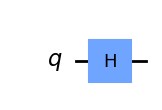

In [3]:
cir = qiskit.QuantumCircuit(1); cir.h(0); cir.draw('mpl')    # use Hadamard gate to put qubit in state |0>+|1>

Now suppose we pass the output beam $\ket{\rightarrow}$ through a second SG apparatus aligned in the $Z$ direction, and the atoms strike a screen after this.  This is equivalent to measuring the $Z$ component of the spin.  Classically, we expect that the atoms have $S_Z=0$ because they emerged from the first SG apparatus with horizontal magnetic moments.  However, in quantum mechanics, the only allowed values are $S_Z = \pm \half$.  Since $\ket{\rightarrow}$ is an equal superposition of $\ket{\uparrow}$ and $\ket{\downarrow}$, we find that on average, 50% of the atoms have $S_Z=\half\hbar$ and the other 50% have $S_Z=-\half\hbar$.  The equivalent quantum circuit is as follows:

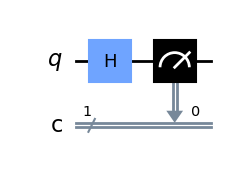

In [4]:
cir = qiskit.QuantumCircuit(1,1); cir.h(0); cir.measure(0,0); cir.draw('mpl')    # measure

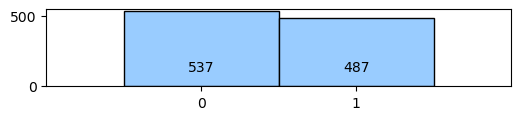

In [5]:
sim = qiskit.Aer.get_backend('aer_simulator')          
exe=qiskit.transpile(cir,sim);res=sim.run(exe).result()  # boilerplate
cts = res.get_counts(exe)
qute.plotHistogram(cts);

## 3. Malus' law

Consider two Stern-Gerlach apparatuses aligned along $(0,0,1)$ and $(\sin\theta,0,\cos\theta)$ respectively.  The effect of the second SGA may be described by a sequence of three quantum gates:
- Rotate the spin by angle $\theta$ clockwise about the $Y$ axis.
- Measure the $Z$ component of the spin.  (In other words, measure the spin in the $\updownarrow$ basis.)
- Rotate the spin by angle $\theta$ counterclockwise about the $Y$ axis.
This experiment is represented by the circuit below:

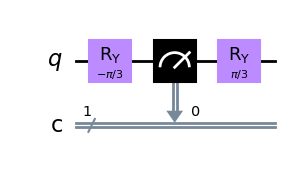

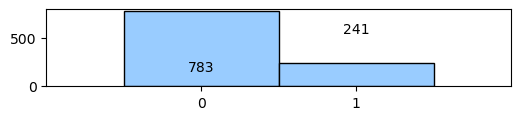

In [6]:
theta = np.radians (60)             # let theta = 60 degrees
cir = qiskit.QuantumCircuit(1,1)     # initialize qubit in "spin up" state
cir.ry (-theta,0)
cir.measure(0,0)
cir.ry (+theta,0)
display(cir.draw('mpl'))             # display circuit
sim = qiskit.Aer.get_backend('aer_simulator')          
exe=qiskit.transpile(cir,sim);res=sim.run(exe).result()  # boilerplate
cts = res.get_counts(exe)
qute.plotHistogram(cts);

Repeat the above experiment for many values of $\theta$:

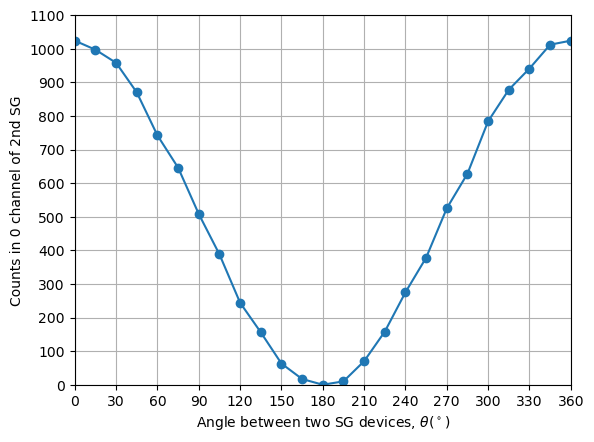

In [7]:
thetas = np.radians (np.arange(0, 361, 15))
sim = qiskit.Aer.get_backend('aer_simulator')  
data = []
def sanitize(x): return x if x else 0
for theta in thetas:
  cir = qiskit.QuantumCircuit(1,1)     # initialize qubit in "spin up" state
  cir.ry (-theta,0)
  cir.measure(0,0)
  cir.ry (+theta,0)
  exe=qiskit.transpile(cir,sim);res=sim.run(exe).result()  # boilerplate
  cts = res.get_counts(exe)
  data.append (sanitize(cts.get('0')))
plt.plot (np.degrees(thetas), data, 'o-')
plt.xlabel (r'Angle between two SG devices, $\theta ({}^\circ)$'); plt.xticks (np.arange(0,361,30)); plt.xlim(0,360)
plt.ylabel ('Counts in 0 channel of 2nd SG'); plt.yticks (np.arange(0,1200,100)); plt.ylim (bottom=0)
plt.grid ('on');

The figure above shows that the number of atoms emerging from the '0' channel of the 2nd Stern-Gerlach apparatus is $N(\theta) \propto \cos^2 \frac{\theta}{2}$.  This is one version of Malus' law.

Let's consider a more sophisticated experiment where a beam of unpolarized atoms is first ``measured'' by a SG apparatus at angle $\theta_1$, and then by another SG apparatus at angle $\theta_2$:

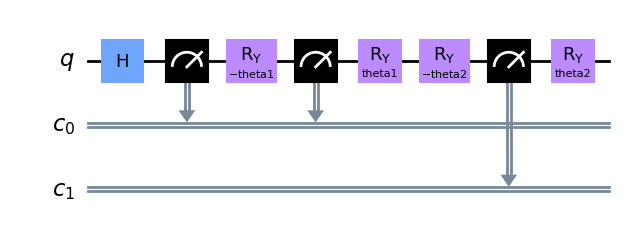

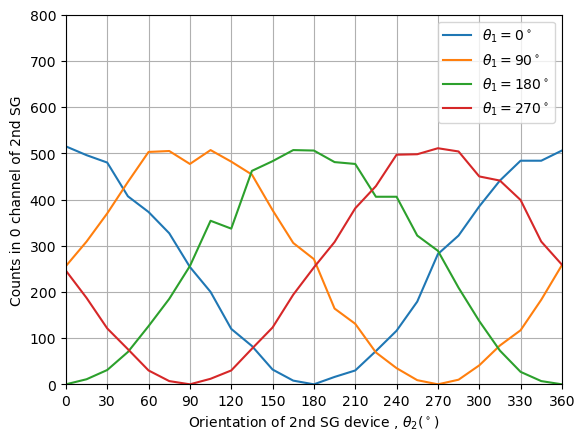

In [8]:
theta1 = qiskit.circuit.Parameter('theta1')
theta2 = qiskit.circuit.Parameter('theta2')
mtheta1 = qiskit.circuit.Parameter('-theta1')
mtheta2 = qiskit.circuit.Parameter('-theta2')
cir = qiskit.QuantumCircuit(1,2)
cir.h (0)                            # initialize qubit in superpositions
cir.measure(0,0)                     # generate random spin either in "up" or "down" states
cir.ry (mtheta1,0); cir.measure(0,0); cir.ry (theta1,0) # measure along direction theta1
cir.ry (mtheta2,0); cir.measure(0,1); cir.ry (theta2,0) # measure along direction theta2
display(cir.draw('mpl', cregbundle=False) )

sim = qiskit.Aer.get_backend('aer_simulator')  
datas = []
t1list = np.radians ([0,90,180,270])
t2list = np.radians (np.arange(0, 361, 15))
for t1 in t1list:
  data = []
  for t2 in t2list:
    bcir = cir.bind_parameters({theta1:t1, theta2:t2, mtheta1:-t1, mtheta2:-t2})
    exe=qiskit.transpile(bcir,sim);res=sim.run(exe).result()  # boilerplate
    cts = res.get_counts(exe)
    data.append (sanitize(cts.get('00')))
  datas.append (data)
for i,data in enumerate(datas):
  plt.plot (np.degrees(t2list), data, '-', label=fr'$\theta_1 = {np.degrees(t1list[i]):.0f}^\circ$')
plt.xlabel (r'Orientation of 2nd SG device , $\theta_2 ({}^\circ)$'); plt.xticks (np.arange(0,361,30)); plt.xlim(0,360)
plt.ylabel ('Counts in 0 channel of 2nd SG'); plt.yticks (np.arange(0,1200,100)); plt.ylim (bottom=0, top=800)
plt.grid ('on'); plt.legend();

The figure above shows that the number of atoms that emerge from the '0' output ports of both SG devices is proportional to $\cos^2 \frac{\theta_2 - \theta_1}{2}$.  This is a more complete version of Malus' law for spins.

Malus' law takes many different forms including $\cos\theta$, $\cos 2\theta$, $\cos^2 \theta$, and $\cos^2 \frac{\theta}{2}$.  This is because:
- the quantum objects may be qubits (0 or 1), spins (up or down), or photons (horizontal or vertical)
- in some experiments one detects counts in both channels (0 or 1), whereas in other experiments one only detects counts in one channel

## 4. Bell states, the Bell inequality, and the EPR paradox

Make a 2-qubit circuit that constructs the Bell state $\ket{\Psi} = \frac{1}{\sqrt{2}} \ket{00} + \frac{1}{\sqrt{2}} \ket{11}$.  Then measure the two qubits along different directions described by $\theta_1$ and $\theta_2$:

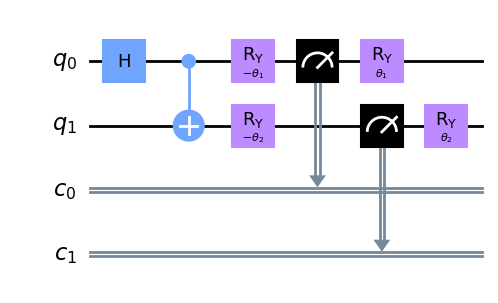

In [9]:
theta1 = qiskit.circuit.Parameter(r'$\theta_1$')
theta2 = qiskit.circuit.Parameter(r'$\theta_2$')
mtheta1 = qiskit.circuit.Parameter(r'-$\theta_1$')
mtheta2 = qiskit.circuit.Parameter(r'-$\theta_2$')
cir = qiskit.QuantumCircuit(2,2)
cir.h(0)
cir.cx(0,1)
cir.ry (mtheta1,0); cir.measure(0,0); cir.ry (theta1,0) # measure along direction theta1
cir.ry (mtheta2,1); cir.measure(1,1); cir.ry (theta2,1) # measure along direction theta2
display(cir.draw('mpl', cregbundle=False))

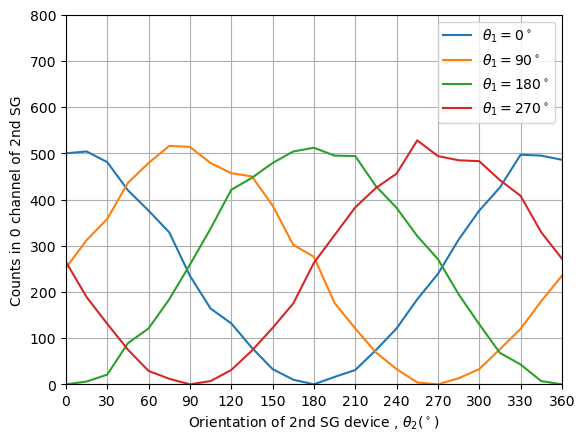

In [10]:
sim = qiskit.Aer.get_backend('aer_simulator')  
datas = []
t1list = np.radians ([0,90,180,270])
t2list = np.radians (np.arange(0, 361, 15))
for t1 in t1list:
  data = []
  for t2 in t2list:
    bcir = cir.bind_parameters({theta1:t1, theta2:t2, mtheta1:-t1, mtheta2:-t2})
    exe=qiskit.transpile(bcir,sim);res=sim.run(exe).result()  # boilerplate
    cts = res.get_counts(exe)
    data.append (sanitize(cts.get('00')))
  datas.append (data)
for i,data in enumerate(datas):
  plt.plot (np.degrees(t2list), data, '-', label=fr'$\theta_1 = {np.degrees(t1list[i]):.0f}^\circ$')
plt.xlabel (r'Orientation of 2nd SG device , $\theta_2 ({}^\circ)$'); plt.xticks (np.arange(0,361,30)); plt.xlim(0,360)
plt.ylabel ('Counts in 0 channel of 2nd SG'); plt.yticks (np.arange(0,1200,100)); plt.ylim (bottom=0, top=800)
plt.grid ('on'); plt.legend();

The figure above shows that the '00' coincidence rate (when the first qubit measured along direction $\theta_1$ is '0' and the second qubit measured along direction $\theta_2$ is '0') is proportional to $\cos^2 \frac{\theta_2 - \theta_1}{2}$.  The graph and the expression are the same as for Malus' law, but the physics is very different! 
- In a Malus experiment, a single quantum object is measured twice, in succession, along different directions.
- In an EPR experiment, two entangled quantum objects are measured along different directions.

## 5. BB84 quantum key distribution protocol

In the BB84 protocol, the sender (Alice) initializes a spin in 1 of 4 states.  The receiver (Bob) measures the spin in 1 of 2 bases.  Alice and Bob subsequently compare a subset of their measurement results, over a classical channel.  The remaining results, which were never transmitted over a classical channel, constitute a key that is shared by both Alice and Bob.  

If an eavesdropper is present (Eve), she intercepts a spin from Alice and measures the spin in 1 of 2 bases before transmitting it to Bob.  This has a finite probability of corrupting the spin, resulting in Alice and Bob becoming aware that an eavesdropper is present.

We can simulate the BB84 protocol within Qiskit as follows.
- Alice applies 1 of 4 gate sequences (I, X, H, or HX) to initialize a spin in $\ket{\uparrow}$, $\ket{\downarrow}$, $\ket{\rightarrow}$, or $\ket{\leftarrow}$.
- Eve applies 1 of 2 gate sequences (M or HMH) to measure the spin in either the $\updownarrow$ or $\leftrightarrow$ basis.
- Bob applies 1 of 2 gate sequences (M or HMH) to measure the spin in either the $\updownarrow$ or $\leftrightarrow$ basis.
Note that there are 16 distinct possibilities.  Run the code below several times to see various possibilities.

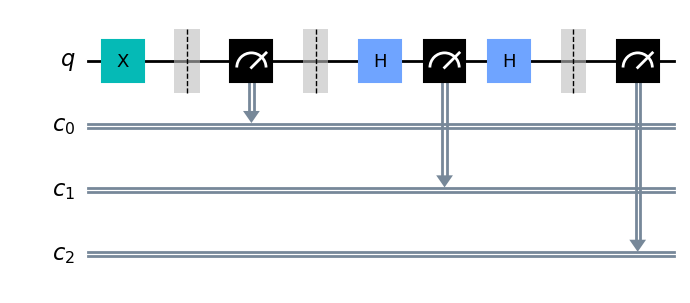

Alice's basis:  |   Alice's spin:  v
Eve's basis:    -   Eve's spin:    >
Bob's basis:    |   Bob's spin:    v
Alice and Bob chose the same bases.  Eve guessed the wrong basis.  However, Bob measured the same spin value as Alice.  Eve goes undetected.


In [11]:
rng = np.random.default_rng()
bA = rng.integers (2)
sA = rng.integers (2)
cir = qiskit.QuantumCircuit(1,3)
if sA: cir.x(0)  # If Alice's spin is '1', apply a NOT gate
if bA: cir.h(0)  # If Alice's basis is 'horizontal', apply a Hadamard gate
cir.barrier()

if bA: cir.h(0); cir.measure(0,0); cir.h(0) # Alice measures in horizontal basis
else:  cir.measure(0,0)                     # Alice measures in vertical basis
cir.barrier()                               # result is recorded in classical bit c0

bE = rng.integers (2)
if bE: cir.h(0); cir.measure(0,1); cir.h(0) # Record Bob's observation in classical bit c1
else:  cir.measure(0,1)
cir.barrier()                               # result is recorded in classical bit c0

bB = rng.integers (2)
if bB: cir.h(0); cir.measure(0,2); cir.h(0) # Record Eve's observation in classical bit c2
else:  cir.measure(0,2)
  
display(cir.draw('mpl', cregbundle=False))
sim = qiskit.Aer.get_backend('aer_simulator')  
exe=qiskit.transpile(cir,sim);res=sim.run(exe,shots=1).result()  # boilerplate
cts = res.get_counts(exe)
sA,sE,sB = [int(s) for s in list(cts) [0]]
spinChar = np.array ([['^','v'],['>','<']])
print ("Alice's basis: ", '-' if bA else '|', "  Alice's spin: ", spinChar[bA,sA])
print ("Eve's basis:   ", '-' if bE else '|', "  Eve's spin:   ", spinChar[bE,sE])
print ("Bob's basis:   ", '-' if bB else '|', "  Bob's spin:   ", spinChar[bB,sB])
if bB != bA:
  print ('Alice and Bob chose different bases.  They discard the results.')
if bB == bA:
  if bE == bA:
    print ('Alice and Bob chose the same bases.  Eve also chose the same basis.  Eve goes undetected.')
  elif sB == sA:
    print ("Alice and Bob chose the same bases.  Eve guessed the wrong basis.  However, Bob measured the same spin value as Alice.  Eve goes undetected.")
  elif sB != sA:
    print ("Alice and Bob chose the same bases.  Eve guessed the wrong basis.  Bob measured the opposite spin value from Alice.  Eve is caught!")
    

The above simulation assumes that Alice and Bob always compare their measurement results.  In the actual BB84 protocol, Alice and Bob choose *not* to compare some of their measurements.  Those measurements become the quantum key that is shared between Alice and Bob.

## Exercises

In a well-known experiment, a flashlight emitting unpolarized light is shone at a stack of two polarizing filters at 90${}^\circ$ to each other.  The transmitted fraction of light is 0%.  When a third filter is inserted between the first two filters and aligned at 45${}^\circ$, it is found that 12.5% of the light is now transmitted through the stack.
Each polarizing filter acts like a measurement. 
- If the measurement gives '0' the photon is transmitted.
- If the measurement gives '1' the photon is absorbed.

The above experiment can be rewritten in the language of spin.  A beam of spin-half atoms is shone at a series of Stern-Gerlach filters (SGFs).  Each SG filter splits the beam into two parts depending on the component of spin along the filter axis, and only one part is transmitted.  Each SG filter acts like a measurement:
- If the measurement gives '0' the atom is transmitted.
- If the measurement gives '1' the atom is blocked.

Simulate the two-filter experiment in Qiskit as follows:

1. Generate a random spin in the Z basis (up or down) using a Hadamard gate followed by a measurement gate.
2. Perform a measurement in the +Z direction.  (Save the result in classical bit 0.)
3. Perform a measurement in the -Z direction.  (Save the result in classical bit 1.)
4. Run the simulation many times.  Show that the outcome '00' (atom transmitted through both SG filters) never occurs.

Simulate the three-filter experiment in Qiskit as follows:

5. Generate a random spin in the Z basis (up or down) using a Hadamard gate followed by a measurement gate.
6. Perform a measurement in the +Z direction.
7. Perform a measurement in the +X direction.
8. Perform a measurement in the -Z direction.
9. Run the simulation many times.  Show that the outcome '000' (atom transmitted through all 3 SG filters) occurs with probability 12.5%.


### Solutions

Fraction of atoms transmitted through both filters:  0.0


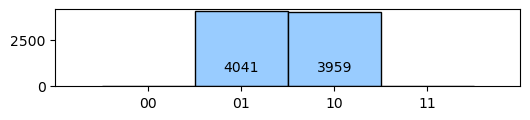

In [15]:
cir = qiskit.QuantumCircuit(1,2)
cir.h (0)                            # initialize qubit in superpositions
cir.measure(0,0)                     # generate random spin either in "up" or "down" states (and discard result)

cir.measure(0,0)                     # measure in +Z direction

cir.x(0)
cir.measure(0,1)                     # measure in -Z direction
cir.x(0)

res = qute.run (cir, shots=8000)
cts = qute.getCounts(res)
cts = qute.padCounts(cts,2)
qute.plotHistogram (cts)
print ('Fraction of atoms transmitted through both filters: ', cts['00']/np.sum([int(s) for s in cts.values()]))

Fraction of photons transmitted through all 3 filters:  0.12225


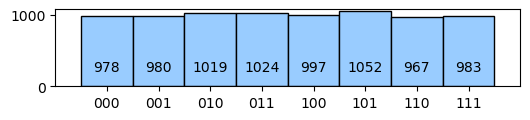

In [14]:
cir = qiskit.QuantumCircuit(1,3)
cir.h (0)                            # initialize qubit in superpositions
cir.measure(0,0)                     # generate random spin either in "up" or "down" states (and discard result)

cir.measure(0,0)                     # measure in +Z direction (not really necessary to do this again)

cir.h(0)
cir.measure(0,1)                     # measure in +X direction
cir.h(0)

cir.x(0)
cir.measure(0,2)                     # measure in -Z direction
cir.x(0)

res = qute.run (cir, shots=8000)
cts = qute.getCounts(res)
cts = qute.padCounts(cts,3)
qute.plotHistogram (cts)
print ('Fraction of photons transmitted through all 3 filters: ', cts['000']/np.sum([int(s) for s in cts.values()]))